# Lesson 14.1 数据归一化与Batch Normalization理论基础

&emsp;&emsp;数据归一化是机器学习领域的一种对数据处理的常规方式。在传统机器学习领域，由于各特征的量纲不一致，可能出现建模过程中量纲较大的特征得不到有效学习的情况，而通过归一化处理之后的数据可以统一放缩在一个区间内，从而避免的各量纲的学习偏差问题，并且我们发现，归一化处理之后的数据能够能够提升模型训练效率、加快模型收敛速度、提升模型稳定性。当然，在传统机器学习领域，有很多需要确保模型可解释的情况，而对数据进行归一化处理会降低模型本身的可解释性。      
&emsp;&emsp;而在深度学习领域，正如上一节所论述的一样，将数据处理成Zero-centered Data，将能够有效确保模型各层学习的有效性，缓解梯度消失和梯度爆炸的情况发生，并且深度学习并不要求可解释性，因此数据标准化并不存在太多障碍。      
&emsp;&emsp;当然，深度学习的数据归一化和经典机器学习的归一化有较大差别，但本质上理论是相通的，本节先从经典机器学习的归一化算法开始讨论，再逐步过渡到深度学习的数据归一化方法。

## 一、经典机器学习的归一化算法

&emsp;&emsp;经典机器学习领域的数据归一化算法主要有两种，分别是0-1标准化（Max-Min Normalization）和Z-Score标准化。二者使用效果差别不大，并且都是逐列对输入的数据进行处理。

### 1.经典机器学习归一化方法回顾

#### 1.1 0-1标准化方法

&emsp;&emsp;0-1标准化是最简单也是最容易想到的方法，同时也是经典机器学习领域最常用的标准化方法。该方法通过在输入特征中逐列遍历其中里的每一个数据，将Max和Min的记录下来，并通过Max-Min作为基数（即Min=0，Max=1）进行数据的归一化处理，基本公式为：

$${x}_{normalization}=\frac{x-Min}{Max-Min}$$

也就是每一列中的元素减去当前列的最小值，再除以该列的极差。PyTorch中我们可以借助张量的广播运算、通过以下方法对数据进行0-1标准化。

In [ ]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

# 自定义模块
from torchLearning import *

# 导入以下包从而使得可以在jupyter中的一个cell输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
t = torch.arange(12).reshape(6, 2).float()
t

tensor([[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 11.]])

In [ ]:
 t.max(0)

tensor([10., 11.])

In [ ]:
t_max = t.max(0)[0]           # 提取每列最大值
t_max

tensor([10., 11.])

In [ ]:
t_min = t.min(0)[0]           # 提取每列最小值
t_min

tensor([0., 1.])

In [ ]:
(t - t_min) / (t_max - t_min)  # 计算0-1标准化后结果

tensor([[0.0000, 0.0000],
        [0.2000, 0.2000],
        [0.4000, 0.4000],
        [0.6000, 0.6000],
        [0.8000, 0.8000],
        [1.0000, 1.0000]])

至此，我们将t的两列都放缩到了0-1区间内，从而保证了模型对各列的学习状况不受量纲影响。不过在深度学习领域，我们更希望输入模型的数据是Zero-Centered Data，此时Z-Score标准化会更加合适。

#### 1.2 Z-Score标准化

&emsp;&emsp;和0-1标准化不同，Z-score标准化利用原始数据的均值（mean）和标准差（standard deviation）进行数据的标准化。同样是逐列进行操作，每一条数据都减去当前列的均值再除以当前列的标准差。很明显，通过这种方法处理之后的数据是典型的Zero-Centered Data，并且如果原数据服从正态分布，通过Z-Score处理之后将服从标准正态分布。Z-Score标准化计算公式如下：

$${x}_{normalization}=\frac{x-\mu }{\sigma }$$

其中$\mu$代表均值，$\sigma$代表标准差。当然，我们也可通过如下方式对张量进行Z-Score标准化处理。

In [ ]:
t

tensor([[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 11.]])

In [ ]:
t.mean(0)

tensor([5., 6.])

In [ ]:
t.std(0)

tensor([3.7417, 3.7417])

In [ ]:
(t - t.mean(0)) / t.std(0)

tensor([[-1.3363, -1.3363],
        [-0.8018, -0.8018],
        [-0.2673, -0.2673],
        [ 0.2673,  0.2673],
        [ 0.8018,  0.8018],
        [ 1.3363,  1.3363]])

能够看出，上述处理之后得到的数据就是Zero-Centered Data。为了后续实验需要，我们可以将Z-Score标准化过程封装为一个函数，方便调用：

In [ ]:
def Z_ScoreNormalization(data):
    stdDf = data.std(0)
    meanDf = data.mean(0)
    normSet = (data - meanDf) / stdDf
    return normSet 

> 一种更加严谨的做法，是在分母项、也就是标准差上加上一个非常小的常数$\mu$，从而使得分母恒大于0。

### 2.经典机器学习归一化算法在深度学习中的实践

&emsp;&emsp;既然Z-Score能够创建Zero-Centered Data，如果我们建模过程中，提前将数据进行Z-Score标准化处理，能否提升模型性能呢？

- 在训练集上训练，测试集上测试

&emsp;&emsp;在建模之前，首先需要明确两个问题，其一是标签是否需要标准化（如果是回归类问题的话），其二是测试集的特征是否需要标准化？

&emsp;&emsp;首先，标签是否标准化对建模没有影响，因此一般我们不会对标签进行标准化；其次，在实际模型训练过程中，由于数据集要划分成训练集和测试集，因此一般来说我们会在训练集的特征中逐行计算其均值和标准差，然后进行模型训练，当输入测试集进行测试时，我们会将在训练集上计算得出的每一列的均值和标准差带入测试集并对测试集特征进行标准化，然后再带入进行模型测试。值得注意的是，此时进行标准化时涉及到的每一列的均值和方差也相当于是模型参数，必须从训练集上得出，不能借助测试集的数据。

- Z-Score建模实验

&emsp;&emsp;接下来，我们尝试先对数据进行标准化，再带入模型进行训练，借此测试Z-Score标准化对深度学习模型的实际效果。注意，此处简化了在训练集上计算均值方差再带入测试集进行操作的流程，直接采用全部数据集进行数据归一化操作。

In [ ]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)
features_norm = Z_ScoreNormalization(features)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)
train_loader_norm, test_loader = split_loader(features_norm, labels)

In [ ]:
# 设置随机数种子
torch.manual_seed(24)  


# 关键参数
lr = 0.03
num_epochs = 40


# 实例化模型
sigmoid_model3 = Sigmoid_class3() 
sigmoid_model3_norm = Sigmoid_class3()  


# 进行Xavier初始化
for m in sigmoid_model3.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
for m in sigmoid_model3_norm.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


# sigmoid_model3模型训练
train_l, test_l = model_train_test(sigmoid_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

# sigmoid_model3_norm模型训练
train_l_norm, test_l_norm = model_train_test(sigmoid_model3_norm, 
                                             train_loader_norm,
                                             test_loader,
                                             num_epochs = num_epochs, 
                                             criterion = nn.MSELoss(), 
                                             optimizer = optim.SGD, 
                                             lr = lr, 
                                             cla = False, 
                                             eva = mse_cal)

Parameter containing:
tensor([[ 0.8590, -0.6975],
        [ 0.1762, -0.7295],
        [ 0.5904,  0.3405],
        [-0.7281, -0.0867]], requires_grad=True)

Parameter containing:
tensor([[-0.5633,  0.1303, -0.5045,  0.3393],
        [-0.7823,  0.2525,  0.7264,  0.5470],
        [ 0.7246, -0.0357, -0.6253,  0.1108],
        [-0.3299, -0.5521,  0.5269,  0.1061]], requires_grad=True)

Parameter containing:
tensor([[ 0.4386,  0.8341,  0.1352, -0.8077],
        [ 0.2441,  0.4123,  0.0232, -0.7393],
        [ 0.8236, -0.8110,  0.6018, -0.0395],
        [ 0.6284, -0.7337,  0.8656,  0.2915]], requires_grad=True)

Parameter containing:
tensor([[0.9703, 0.6656, 0.8244, 0.3487]], requires_grad=True)

Parameter containing:
tensor([[-0.2945,  0.9237],
        [ 0.7596, -0.6387],
        [-0.0023, -0.3001],
        [-0.9573,  0.0271]], requires_grad=True)

Parameter containing:
tensor([[-0.5126, -0.1948, -0.2230,  0.7317],
        [ 0.3355, -0.7767,  0.4933,  0.5650],
        [ 0.3391,  0.3513,  0.3385,  0.0232],
        [-0.7911, -0.4265,  0.5541,  0.2841]], requires_grad=True)

Parameter containing:
tensor([[ 0.6846,  0.2079,  0.8334, -0.3973],
        [-0.4116,  0.3072, -0.4335,  0.3472],
        [ 0.0940, -0.3414,  0.2058,  0.8155],
        [ 0.4660, -0.8182,  0.3571,  0.5147]], requires_grad=True)

Parameter containing:
tensor([[ 0.7612, -0.2644,  0.8887,  0.8696]], requires_grad=True)

然后对比两种模型的运算结果

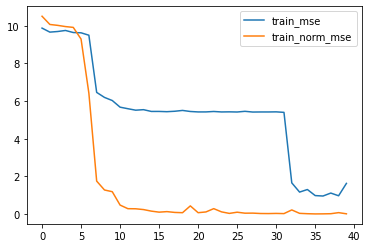

In [ ]:
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), train_l_norm, label='train_norm_mse')
plt.legend(loc = 1)

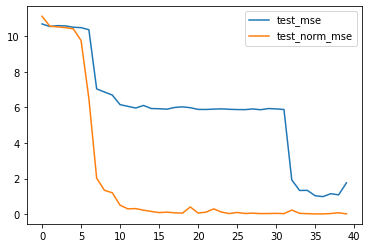

In [ ]:
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.plot(list(range(num_epochs)), test_l_norm, label='test_norm_mse')
plt.legend(loc = 1)

> 值得注意的是，此处我们统一先对模型进行Xavier参数初始化计算然后再使用数据归一化方法，是为了避免不同随机数种子对参数初始化取值的影响，但实际上目前很多神经网络用到的归一化方法（后面会谈到）在最终效果上都能让模型摆脱参数初始化的限制，也就是能够让模型在不使用初始化方法的情况下仍然可以进行快速和稳定的收敛。

&emsp;&emsp;从模型最终运行结果能够看出，经过Z-Score归一化的数据收敛速度更快，在某些情况下也能获得更好的结果，当然我们也能通过微观层面、通过查看各层梯度值来观察数据归一化的效果，验证归一化是否有助于各层梯度保持平稳。

In [ ]:
# 设置随机数种子
torch.manual_seed(24)  


# 关键参数
lr = 0.03
num_epochs = 5


# 实例化模型
sigmoid_model3 = Sigmoid_class3() 
sigmoid_model3_norm = Sigmoid_class3()  


# 进行Xavier初始化
for m in sigmoid_model3.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
for m in sigmoid_model3_norm.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


# sigmoid_model2模型训练
train_l, test_l = model_train_test(sigmoid_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

# sigmoid_model2_norm模型训练
train_l_norm, test_l_norm = model_train_test(sigmoid_model3_norm, 
                                             train_loader_norm,
                                             test_loader,
                                             num_epochs = num_epochs, 
                                             criterion = nn.MSELoss(), 
                                             optimizer = optim.SGD, 
                                             lr = lr, 
                                             cla = False, 
                                             eva = mse_cal)

Parameter containing:
tensor([[ 0.8590, -0.6975],
        [ 0.1762, -0.7295],
        [ 0.5904,  0.3405],
        [-0.7281, -0.0867]], requires_grad=True)

Parameter containing:
tensor([[-0.5633,  0.1303, -0.5045,  0.3393],
        [-0.7823,  0.2525,  0.7264,  0.5470],
        [ 0.7246, -0.0357, -0.6253,  0.1108],
        [-0.3299, -0.5521,  0.5269,  0.1061]], requires_grad=True)

Parameter containing:
tensor([[ 0.4386,  0.8341,  0.1352, -0.8077],
        [ 0.2441,  0.4123,  0.0232, -0.7393],
        [ 0.8236, -0.8110,  0.6018, -0.0395],
        [ 0.6284, -0.7337,  0.8656,  0.2915]], requires_grad=True)

Parameter containing:
tensor([[0.9703, 0.6656, 0.8244, 0.3487]], requires_grad=True)

Parameter containing:
tensor([[-0.2945,  0.9237],
        [ 0.7596, -0.6387],
        [-0.0023, -0.3001],
        [-0.9573,  0.0271]], requires_grad=True)

Parameter containing:
tensor([[-0.5126, -0.1948, -0.2230,  0.7317],
        [ 0.3355, -0.7767,  0.4933,  0.5650],
        [ 0.3391,  0.3513,  0.3385,  0.0232],
        [-0.7911, -0.4265,  0.5541,  0.2841]], requires_grad=True)

Parameter containing:
tensor([[ 0.6846,  0.2079,  0.8334, -0.3973],
        [-0.4116,  0.3072, -0.4335,  0.3472],
        [ 0.0940, -0.3414,  0.2058,  0.8155],
        [ 0.4660, -0.8182,  0.3571,  0.5147]], requires_grad=True)

Parameter containing:
tensor([[ 0.7612, -0.2644,  0.8887,  0.8696]], requires_grad=True)

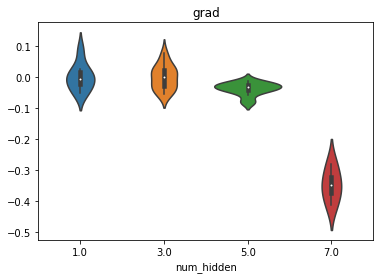

In [ ]:
weights_vp(sigmoid_model3, att="grad")

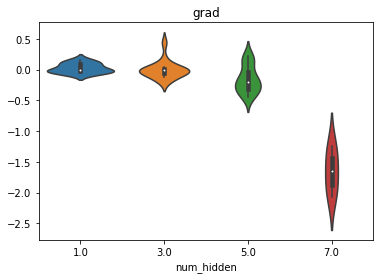

In [ ]:
weights_vp(sigmoid_model3_norm, att="grad")

&emsp;&emsp;由此能看出，使用归一化后的数据进行建模的模型，前几轮迭代时梯度相对平稳。我们知道，当各层梯度更加均衡时模型学习能力更强，进而能够加快模型收敛速度，甚至提升模型准确率。因此我们也可以推断，归一化是通过维持梯度平稳来加快收敛速度、提升模型准确率的。

> 注意，此处所介绍的结论：归一化的实际作用是维持梯度平稳，也可以算是近几年的研究成果，我们只是相当于创造了实验验证了该结论。在早些年，人们人为归一化能够提升模型效果的根本原因是能够一定程度上消除数据偏移问题，相关讨论后面会介绍。

### 3.Z-Score数据归一化的局限

&emsp;&emsp;不过，毕竟Z-Score初始化并不是为深度学习算法量身设计的数据归一化方法，在实际神经网络建模过程中，Z-Score的使用还是存在很多局限，具体来说主要有以下两点。

#### 3.1 Zero-Centered特性消失

&emsp;&emsp;尽管Z-Score归一化能够一定程度保证梯度平稳，进而提升模型收敛速度甚至是提升模型效果，但是，和Xavier初始化方法一样，由于是对于“初始值”的修改，因此也会存在随着迭代次数增加就逐渐破坏了Zero-Centered Data这一条件的问题，当然，该问题也可视作经典机器学习归一化方法应用于深度神经网络时的局限。

&emsp;&emsp;并且，随着参数和输入数据都回到不可控状态，各层的梯度又将回到不可控的状态，而所谓的控制梯度平稳性也将无从谈起。例如，我们尝试创建相对梯度容易不平稳的tanh激活函数模型，查看迭代5轮和40轮时各层梯度变化情况。

In [ ]:
# 设置随机数种子
torch.manual_seed(24)  

# 学习率
lr = 0.03


# 实例化模型
tanh_model2_norm1 = tanh_class2()  
tanh_model2_norm2 = tanh_class2()  


# 进行Xavier初始化
for m in tanh_model2_norm1.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
for m in tanh_model2_norm2.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


# sigmoid_model2模型训练
train_l, test_l = model_train_test(tanh_model2_norm1, 
                                   train_loader_norm,
                                   test_loader,
                                   num_epochs = 5, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

# sigmoid_model2_norm模型训练
train_l_norm, test_l_norm = model_train_test(tanh_model2_norm2, 
                                             train_loader_norm,
                                             test_loader,
                                             num_epochs = 40, 
                                             criterion = nn.MSELoss(), 
                                             optimizer = optim.SGD, 
                                             lr = lr, 
                                             cla = False, 
                                             eva = mse_cal)

Parameter containing:
tensor([[ 0.2847,  0.4558],
        [ 0.1465, -0.3580],
        [-0.3710, -0.0826],
        [ 0.9358,  0.5741]], requires_grad=True)

Parameter containing:
tensor([[ 0.5889, -0.3163,  0.2033, -0.5345],
        [-0.1101, -0.4292,  0.3611,  0.4440],
        [ 0.1075,  0.6876, -0.8603,  0.3756],
        [ 0.4682,  0.7871,  0.1877, -0.7922]], requires_grad=True)

Parameter containing:
tensor([[ 0.7348, -0.0581,  0.3638, -0.7409]], requires_grad=True)

Parameter containing:
tensor([[ 0.0359,  0.9580],
        [ 0.3218,  0.8097],
        [ 0.1927,  0.8312],
        [-0.8618,  0.4136]], requires_grad=True)

Parameter containing:
tensor([[ 0.8077,  0.4030,  0.5159,  0.6062],
        [ 0.7439, -0.6040,  0.1526, -0.6317],
        [ 0.5113,  0.2949, -0.6306, -0.0751],
        [-0.5633,  0.1303, -0.5045,  0.3393]], requires_grad=True)

Parameter containing:
tensor([[-0.9895,  0.3193,  0.9188,  0.6919]], requires_grad=True)

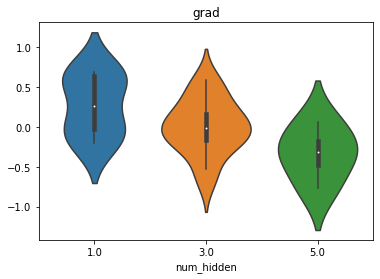

In [ ]:
weights_vp(tanh_model2_norm1, att="grad")

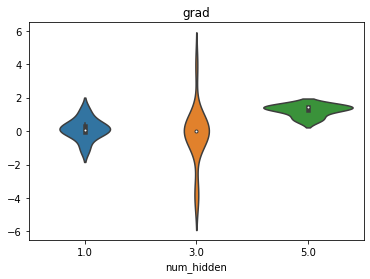

In [ ]:
weights_vp(tanh_model2_norm2, att="grad")

能够看出，刚开始时梯度较为平稳，而迭代到后期时就出现了明显的梯度爆炸现象。

#### 3.2 Zero-Centered Data的作用局限

&emsp;&emsp;除了输入数据在迭代过程中会逐渐丧失Zero-Centered特性外，Z-Score标准化在应用到深度学习模型中，还会面临一个更加严峻的问题——那就是Zero-Centered Data本身作用范围也是有限的。我们哪怕能够维持输入数据的Zero-Centered特性，也很难保证只凭借这一点就能确保梯度平稳。      
&emsp;&emsp;在Lesson 13中，我们知道深度学习中保证各层梯度平稳，是确保模型能够顺利有效进行学习的关键，而所谓的梯度平稳，我们可以用Glorot条件来进行描述，即正向传播过程中数据流经各层时输入和输出数据方差相同，反向传播时数据流经各层前后该层梯度的方差相同。      
&emsp;&emsp;尽管此前我们一直强调零均值数据的良好特性，但归根结底还是因为零均值数据在各层梯度计算过程中，可以使得激活函数导函数输出结果尽可能大（ReLU激活函数时能够避免Dead ReLU Problem），从而确保梯度计算的有效性。此处我们不妨回顾此前我们得出的三层神经网络中各层梯度的计算公式：

$$
grad_1 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
f(F(X*w_1)) \cdot
w_2 \cdot f(X * w_1) \cdot X 
$$

$$
grad_2 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
F(X * w_1) 
$$

$$
grad_3 = \frac{\partial loss}{\partial \hat y} 
\cdot 
F(F(X * w_1) * w_2)
$$

由于各层的梯度实际上受到激活函数、各层输入数据和参数三者共同影响，因此哪怕我们将所有的输入数据都调整为零均值的，各层梯度的计算结果还是有可能因为受到其他因素影响导致不平稳。因此，一味追求输入数据的Zero-Centered或许并不是最好的选择。

> 值得注意的是，由于数据的平移和放缩本身并不影响数据分布，因此理论上是可以对每一层接收到的数据进行归一化的。

### 4.保证梯度平稳的第二条道路：输入数据调整

&emsp;&emsp;不过呢，尽管Z-Score作用有限，但对输入数据进行有效处理，却是至关重要的深度学习模型优化方向。      
&emsp;&emsp;根据上述各层梯度计算公式，不难发现，影响梯度平稳性的核心因素有三个，其一是各层的参数、其二是各线性层接收到的数据、其三则是激活函数。关于参数的优化我们在Lesson 13中已经进行了详细的介绍，简单来说就是通过Glorot条件巧妙设置参数初始值，从而使得各层梯度在计算过程中尽可能更加平稳。但由于参数本身的特殊性，我们只能设置其初始值，一旦模型开始迭代，参数就将开始“不受控制”的调整，初始值的设置是很难长期保证梯度平稳的，这点和Z-Score对数据进行初始化所存在的问题一致。      
&emsp;&emsp;除了参数调整外，在确保梯度平稳性上我们就只剩下选择激活函数和调整输入数据两条路可走。关于新兴激活函数的选择我们将在下一节课进行详细讨论，但对于输入数据的优化，目前来看，应用最为广泛、并且被验证的实践效果最好的数据归一化方法，是由Sergey loffe和Christian Szegedy在2015年发表的[《Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift》](http://de.arxiv.org/pdf/1502.03167)中提出的一种方法，该方法通过修改每一次带入训练的数据分布（每一个Batch）的数据分布，来提升模型各层梯度的平稳性，从而提升模型学习效率、提高模型训练结果。由于是修改每一个Batch的数据分布，因此该方法也被称为Batch Normalization（BN），小批量数据归一化方法。不过需要注意的是，尽管BN也是一种数据归一化方法，但深度学习领域的归一化方法和经典机器学习的归一化方法却存在很大区别，经典机器学习的归一化方法主要是为了消除不同特征的量纲影响而对各列的数据分布进行修改，并且并非所有机器学习模型都要采用数据归一化方法才能进行有效建模，而深度学习归一化方法的目标则是为了确保模型能够进行有效训练为目的，是一种适用于所有模型的一种必要的优化方法。同时，尽管BN是一种针对小批数据的数据归一化方法，但我们不能将其简单想象成就是针对每个小批数据进行类似传统机器学习的归一化操作，并且在使用层面也会相对较难。在学习BN的过程中，首先我们需要了解其背后的优化原理，然后再掌握在PyTorch中的实践方法。

## 二、Batch Normalization基础理论

&emsp;&emsp;尽管目前来看，Batch Normalization已经是被验证的、行之有效的模型优化手段，但BN的诞生及其有效性的原理证明，却有一段有趣的历史。

&emsp;&emsp;根据《Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift》一文中的观点，作者认为在深度神经网络模型训练过程中，容易出现一种名为内部协方差偏移（Internal Covariate Shift、ICS）的问题，该问题会导致模型性能下降，而为了解决该问题，作者提出了BN方法，并在各种实验中验证了BN对模型效果提升的有效性。

&emsp;&emsp;然而，到底什么是ICS，作者在原文中只给出了简单的描述而未给出严格定义，并且对于BN可以提升模型性能方面，作者表示根本原因是因为BN能够消除ICS。有趣的是，尽管这套理论没有在原文中给出更加严谨的说明和论证，但由于BN方法本身在应用实践中效果很好，因此大多数情况下人们并未对原文中论述不严谨的理论推导部分进行深究。直到2018年，来自MIT的研究团队发表论文，[《How Does Batch Normalization Help Optimization?》](https://arxiv.org/pdf/1805.11604.pdf)，研究人员表示，通过一些列严谨的实验可以证明，BN方法对模型优化的有效性和原论文中所描述的消除ICS没有任何关系，甚至在某些场景下BN还会加剧模型的ICS，而到底是什么让BN如此有效，MIT的研究团队最终也没有给出严谨的理论证明。如此一来BN方法就成了基础理论“不成立”但实际上很好用的一项优化方法，而对于BN的有效性的理论研究，也成为了诸多科研团队的命题。      
&emsp;&emsp;不过，尽管BN有效性原理成谜，但MIT的研究团队通过一系列的实验，最终还是给出了一些BN有效性的理论推断，他们判断BN之所以有效，应该是和修改数据分布、从而使得梯度更加平稳有关，也就是该方法之所以能够发挥作用，仍然可能和满足了Glorot条件有关。因此，在介绍BN方法时，我们将不再讨论BN是否能够ICS这一命题，转而探讨是BN如何修正数据分布进而使得模型能够更好满足Glorot条件这一点入手，尽可能帮助学员建立对BN方法有效性的判别依据。      
&emsp;&emsp;深度学习作为“实证型”技术，在很多时候模型效果才是首要考虑因素，因此类似BN这种，虽然理论基础不成立，但实践效果很好的方法在深度学习领域是广泛存在的，但是，这并不意味着我们可以不管不顾只讨论怎么用而忽略背后的理论讨论。对于一名合格的算法工程师，我们还是需要对诸多方法的使用及原理背景树立正确的认知。

### 1.归一化方法与数据分布的相互独立性

&emsp;&emsp;首先，我们需要知道，任何归一化的本质都是对数据进行平移和放缩，所谓平移，就是指数据集每一列统一加上或减去某一个数，在Z-Score中就是每一列减去该列的均值，而所谓的放缩，就是指数据集中每一列数据统一除以或乘以某一个数，在Z-Score中就是每一列除以当前列的标准差。而数据的平移和放缩，是不会影响数据特征的分布情况的。

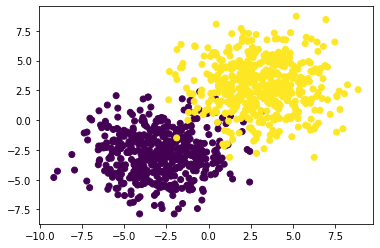

In [ ]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建数据集
features, labels = tensorGenCla(num_class= 2, deg_dispersion=[6, 2])

# 查看其分布
plt.scatter(features[:, 0], features[:, 1], c = labels)

对原数据进行归一化

In [ ]:
features

tensor([[-3.0141, -1.9911],
        [-1.6593, -3.7657],
        [-2.9395, -2.2347],
        ...,
        [ 3.9623,  3.0861],
        [ 1.4535,  0.7860],
        [-1.6681,  4.3935]])

In [ ]:
f = Z_ScoreNormalization(features)

In [ ]:
f

tensor([[-0.8529, -0.5795],
        [-0.4764, -1.0878],
        [-0.8322, -0.6492],
        ...,
        [ 1.0859,  0.8750],
        [ 0.3887,  0.2161],
        [-0.4789,  1.2495]])

然后对比查看归一化前后数据集分布

<AxesSubplot:>

Text(0.5, 1.0, 'features distribution')

<AxesSubplot:>

Text(0.5, 1.0, 'f distribution')

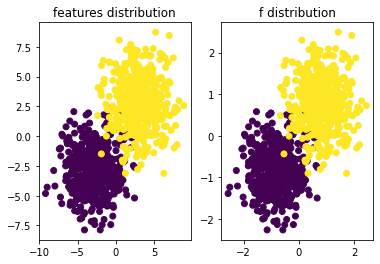

In [ ]:
plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], c = labels)
plt.title('features distribution')
plt.subplot(122)
plt.scatter(f[:, 0], f[:, 1], c = labels)
plt.title('f distribution')

我们发现，归一化前后数据分布不变，但数据在空间中的坐标的绝对值发生变化。当然，我们也可以对原始数据进行任意的平移和放缩，查看是否会改变原数据的分布。

<AxesSubplot:>

Text(0.5, 1.0, 'features distribution')

<AxesSubplot:>

Text(0.5, 1.0, 'f distribution')

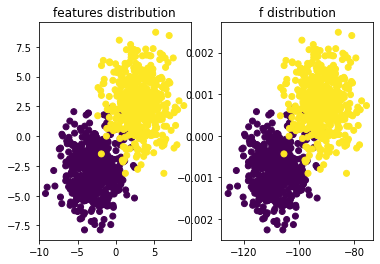

In [ ]:
plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], c = labels)
plt.title('features distribution')
plt.subplot(122)
plt.scatter(f[:, 0]*10-100, f[:, 1]*0.001, c = labels)
plt.title('f distribution')

&emsp;&emsp;而比较重要的一点是，数据的分布其实就代表着数据背后的规律，我们使用模型去捕捉数据规律，其实就是对数据分布情况进行学习。因此，数据归一化不修改数据分布，是我们使用归一化方法的基本前提，否则，一旦数据归一化方法会修改数据分布，则相当于是人为破坏了数据原始规律，这将会对后续的模型学习造成巨大的影响。

> 在任何情况下，机器学习建模都应避免人为修改数据规律，因为一旦加入人为创造的规律，算法也会不加区分的进行学习。

### 2.归一化与仿射变换

&emsp;&emsp;需要补充的第二点基础理论就是，归一化的本质仍然是对数据进行仿射变换。根据此前介绍，数据的仿射变换用矩阵形式来进行表示就是：$$\hat x = x * w + b$$其中x是原数据，w是参数矩阵，b是截距，$\hat x$是经过变换之后的数据。此处以Z-Score为例，探讨归一化操作转化为仿射变换的方法。

In [ ]:
# 创建一组数据
f = torch.arange(1, 5).reshape(2, 2).float()
f

tensor([[1., 2.],
        [3., 4.]])

In [ ]:
# 对其进行Z-Score归一化
Z_ScoreNormalization(f)

tensor([[-0.7071, -0.7071],
        [ 0.7071,  0.7071]])

在归一化运算时，我们进行了如下操作：

$$\frac{x-mean(x)}{std(x)}$$

当然，该过程也可以写成如下表达式：

$$\frac{x}{std(x)} - \frac{mean(x)}{std(x)} = x \cdot\frac{1}{std(x)}- \frac{mean(x)}{std(x)} = x \otimes \gamma + \beta$$

其中$\otimes$表示逐个元素相乘，$\gamma 和\beta$为指代参数。

In [ ]:
r = torch.tensor(1.) / f.std(0)     # 每列的标准差

而原数据每列的标准差分之一和原始数据的每一列相乘，可以通过如下矩阵相乘形式计算得出：

In [ ]:
rm = torch.diag(r)                  # 构建以每列标准差分之一为对角线元素的对角矩阵
rm

tensor([[0.7071, 0.0000],
        [0.0000, 0.7071]])

In [ ]:
torch.mm(f, rm)                     # 计算得出每一列除以标准差之后的结果

tensor([[0.7071, 1.4142],
        [2.1213, 2.8284]])

In [ ]:
f / f.std(0)

tensor([[0.7071, 1.4142],
        [2.1213, 2.8284]])

In [ ]:
b = -(f.mean(0) / f.std(0))
b

tensor([-1.4142, -2.1213])

In [ ]:
torch.mm(f, rm) + b

tensor([[-0.7071, -0.7071],
        [ 0.7071,  0.7071]])

In [ ]:
Z_ScoreNormalization(f)

tensor([[-0.7071, -0.7071],
        [ 0.7071,  0.7071]])

&emsp;&emsp;至此，我们可以发现，在归一化的过程中，放缩的部分可以通过矩阵乘法来完成，假设原数据为一个m*n的数据集，则令其左乘一个对角线元素为原数据集每一列放缩参数的矩阵即可完成放缩，而平移部分则更加简单，令数据集加上由每一列平移幅度所构成的向量即可完成平移。

&emsp;&emsp;而如果归一化是一种放射变换，并且归一化的计算过程可以用矩阵运算来完成，那么就有两方面的直接影响，其一，PyTorch中对数据的仿射变换是用线性层完成的，既然归一化是一种特殊的仿射变换，归一化的操作也可以由一个特殊的线性层来完成，并且和所有的线性层一样，归一化层也可以放置在任何隐藏层前后；其二，在具体实现层面上，在仿射变换中我们是可以设置参数、并且通过构建损失函数再利用梯度下降进行求解的，那么对于归一化这种特殊的仿射变换，平移和放缩的尺度是否可以简单设计成一个参数，然后带入模型进行训练求解呢?

&emsp;&emsp;当然是可以的，并且这么做是非常有必要的！如前文所述，将数据转化为Zero-Centered Data并非最好的选择，如果可以通过梯度下降求解出最佳放缩和平移的尺度，大概率会比简单使用Z-Score将其放缩为均值为0、方差为1的数据分布效果更好（至少不会差）。另外，我们将归一化操作看成一个特殊的线性层，也将极大拓展归一化操作可以出现的位置。在经典机器学习领域，对数据的归一化只停留在输入数据时对数据进行统一处理，但正如前文所述，如果只对初始输入数据进行归一化，那么在迭代过程中，数据会逐渐失去初始化之后所带来的良好特性，此时如果我们可以像添加线性层一样，在任意隐藏层前后添加归一化层，则可以在迭代的每个环节对数据进行归一化，如此一来就能避免迭代过程中数据逐渐偏移所导致的梯度不平稳问题。

&emsp;&emsp;而实际上，BN就是这么做的。在BN中，以每次输入的小批数据为训练数据，我们将平移和放缩的尺度视作参数，通过带入模型进行训练，最终得出最佳平移和放缩尺度，并且这种BN归一化层会可以出现在任意隐藏层的前后，为数据传输的每一步进行归一化操作。具体原理如下节所示。

> 当然，这里需要补充一点。将平移和放缩的尺度视为参数，则代表我们不是朝着零均值的方向去进行归一化处理，实际上在参数化尺度的时候，参数迭代的方向自然就变成了尽量保持各层梯度平稳，这也是参数化归一化尺度的有效性的最佳证明。相关数学原理可参考上述两篇论文，课上不对此进行拓展。

> 实际上，均值为0、方差为1的归一化却是也不一定是最优选择，根据各层梯度计算公式不难看出，最佳的数据归一化方法并不是绝对的0均值1方差，而是能够使得最终各变量相乘之后梯度保持均衡。$$
grad_1 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
f(F(X*w_1)) \cdot
w_2 \cdot f(X * w_1) \cdot X 
$$
$$
grad_2 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
F(X * w_1) 
$$
$$
grad_3 = \frac{\partial loss}{\partial \hat y} 
\cdot 
F(F(X * w_1) * w_2)
$$

### 3.Batch Normalization基本流程

&emsp;&emsp;有了基本认知之后，接下来我们来讨论Batch Normalization的基本实现流程。作为针对数据归一化方法，Batch Normalization的理论实现流程看似更加复杂，但实际上，和所有的归一化方法一样，BN做的也就是对输入数据进行平移和放缩。只不过BN的平移和放缩分为两个阶段，第一个阶段是进行Z-Score处理，也就是将输入数据的均值平移至0点，并将输入数据的方差放缩至1；第二阶段则是在此基础上在对数据的均值进行参数平移（加上一个通过训练、也就是梯度下降算法算得的参数），并对其方差进行参数（另一个通过模型训练、也就是梯度下降算得的参数）放缩。具体数学过程如下：

Stage 1：Z-Score放缩

$$\mu_B = \frac{1}{m_B}\sum^{m_B}_{i=1}x^{(i)}$$

$$\delta^2_B=\frac{1}{m_B}\sum^{m_B}_{i=1}(x^{(i)}-\mu_B)^2$$

$$\hat{x}^{(i)} = \frac{x^{(i)}-\mu_B}{\sqrt{\delta^2_B+\epsilon}}$$

&emsp;&emsp;其中$\mu_B$代表输入的小批数据均值，$\delta^2_B$代表输入的小批数据方差，$\hat{x}$代表Z-Score归一化后的数据结果，和此前一样，Z-Score计算过程为减去每一列的元素减去该列的均值除以该列的修正后的标准差（方差加上一个极小的数使得其不为零）。第一阶段的参数都是可以计算或者人工设置的，其中均值和方差都是简单计算即可得出，而修正项$\epsilon$则是可以手动设置的。

Stage 2：带参数的平移和放缩

$$z^{(i)}=\gamma \otimes \hat{x}^{(i)}+\beta$$

&emsp;&emsp;和第一阶段参数可以简单计算得出不同，二阶段的参数，也就是$\gamma$和$\beta$都是模型参数，在实际模型训练过程中是需要作为模型整体参数的一部分，带入损失函数、进而通过梯度下降计算得出的。而二阶段的实际处理数据过程，则是首先对一阶段放缩之后每一列的$\hat{x}$乘以一个固定的$\gamma$在加上一个固定的$\beta$。需要强调的是，上述公式是针对列进行处理，即每一列都乘以一个$\gamma$再加上一个$\beta$，并不是所有数据都乘以一个$\gamma$再加上一个$\beta$，也不是每一个数据都乘以一个$\gamma$再加上一个$\beta$。

- BN的两个阶段之间关系

&emsp;&emsp;细心的同学不难发现，实际上BN的第一个阶段和第二个阶段都是在做同一件事——都是在对数据进行平移和放缩，甚至当$\gamma=\sqrt{\delta^2_B+\epsilon}, \beta=\mu_B$，二阶段处理结果将还原回原始输入数据，也就是$z^{(i)}=x^{(i)}$

&emsp;&emsp;既然两个阶段做的相同的事情，为何不能直接合并为一个阶段。从理论上来说，我们可以将上述过程合并为：

$$\begin{aligned}
z^{(i)} 
& = \gamma \otimes \hat{x}^{(i)}+\beta \\
& = \gamma \otimes \frac{x^{(i)}-\mu_B}{\sqrt{\delta^2_B+\epsilon}} + \beta \\
& = \frac{\gamma}{\sqrt{\delta^2_B+\epsilon}}\otimes x^{(i)}+(\beta-\frac{\gamma \cdot \mu_B}{\sqrt{\delta^2_B+\epsilon}}) \\
& = \hat\gamma \otimes {x}^{(i)}+\hat \beta \\
\end{aligned}
$$

&emsp;&emsp;但在实际建模过程中我们并没有这么做，实际PyTorch模型训练完成后输出的参数结果也是原始的$\gamma和\beta$。这里我们可以这样理解：BN方法无疑会增加模型计算量，而提前对数据进行Z-Score处理，就相当于是先选择了一组初始的$\gamma和\beta$对数据进行处理（此时$\gamma_0=\frac{1}{\sqrt{\delta^2_B+\epsilon}}, \beta_0 = \frac{-\mu_B}{\sqrt{\delta^2_B+\epsilon}}$），然后再此基础之上进行带参数的平移和缩放，二阶段平移和缩放的参数是需要经过梯度下降迭代计算得出，而选择在$\gamma_0和\beta_0$基础上进行梯度下降计算，就相当于选择了一组初始值点，而该初始值点能够有效提升迭代收敛速度。

- 数据归一化与仿射变换

&emsp;&emsp;根据前文论述我们知道，数据归一化本质也是对数据进行一种特殊的仿射变换，并且在PyTorch中，仿射变换是能通过矩阵运算来实现。既然如此，我们在PyTorch中进行BN归一化的操作其实就可以视作添加了一层特殊的线性层来进行计算，其中线性层的参数就是$\gamma和\beta$，实际的计算过程如下：

$$x * diag(\frac{\gamma}{\sqrt{\delta^2_B+\epsilon}}) +(\beta-\frac{\gamma \cdot \mu_B}{\sqrt{\delta^2_B+\epsilon}})$$

也就相当于$$x*w+b$$

> 这里需要注意的是，$\gamma和\beta$都是列向量，和$\mu、\delta$一样，每个元素对应输入数据的一列。

并且我们需要知道两种特殊情况，其一，当$\gamma = 1, \beta=0$时，上述仿射变换过程就退化为Z-Score变换；其二，当$\gamma=\sqrt{\delta^2_B+\epsilon}, \beta=\mu_B$时，就相当于退回原始数据集。

### 4.Batch Normalization方法有效性认知

&emsp;&emsp;接下来，我们从理论角度，简单分析BN方法的实际作用。我们知道，一旦$\gamma和\beta$训练完成、也就是数值确定，经过BN处理完的数据将朝向方差为$\gamma$、均值为$\beta$的分布方向靠拢。也就是BN作为一种特殊的仿射变换，会调整经过BN层的数据分布，而数据分布的均值和方差又是由模型训练得到的，并不一定像Z-Score一样是调整为0均值1方差的数据分布，因此我们可以理解为BN在调整数据分布时其实是朝着最有利于提升模型效果的方向调整，或者说，朝着满足损失函数能取得更小数值的方向调整。在这个过程中，调整后的数据分布可以以任何形态出现，并不局限于0均值和1方差的数据分布，这一点是BN方法和Z-Score方法最核心的区别，当然，如果我们反向论证，如果最终模型算得最佳分布不是0均值1方差的分布，那么也就说明Z-Score归一化方法并不是适用于当前模型的最佳归一化方法。      
&emsp;&emsp;另外，我们前面也讨论过，对数据进行归一化处理，也就是放缩和平移，其实是不会改变数据分布规律的，因此我们可以在模型训练的任何时候、任意阶段对数据进行放缩和平移。而BN方法本身又是一种数据分布自适应的方法，可以根据实际情况训练出最合适的数据分布，因此我们可以将BN方法放置于神经网络的各个线性层前后的，协助模型即时调整数据在每一层的分布。当然，就像此前说的一样，其实我们也可以对每一层数据进行Z-Score处理，但可想而知，效果应当不如数据分布自适应的BN方法好。      
&emsp;&emsp;如果这种自适应的数据分布调整是朝向损失函数取值更小的方向调整，并且数据分布直接影响的就是各线性层的梯度平稳行，而梯度平稳又是保证模型有效性的根本原因之一，据此我们或许也可以从理论上推导出这种数据分布上的自适应的调整确实是朝向保证模型梯度平稳的方向调整的。

### 5.Batch Normalization的训练和测试过程

&emsp;&emsp;理论阶段的最后一部分，我们补充一下关于BN方法在测试集上的使用过程。      
&emsp;&emsp;对于传统机器学习的归一化方法来说，在训练集上进行训练、在测试集上进行测试的流程相对比较清晰，用于测试集归一化的参数是从训练集当中计算而来的，也就是说在对测试集进行归一化时，均值和方差都是训练集中数据计算结果。当然，对于BN方法来说，这一点仍然没变，只不过由于BN方法是针对每一个小批数据进行归一化，并且计算过程也是使用了整体均值和方差的无偏估计，尽管当模型训练完成时将算出$\gamma和\beta$的值，但当带入测试数据进行向前传播时，均值和方差仍然是需要计算的数值。这里由于测试集可能是一条条数据进来，因此我们是不能使用测试集的均值和方差对整体进行无偏估计的。为解决该问题，BN方法一般都会配套一个记录训练数据整体均值和方差的方法，并且为了做到训练阶段和测试阶段使用不同的计算方式，在PyTorch中调用BN方法时也会涉及到关于模型状态切换的相关内容。

以上就是Batch Normalization的基础理论介绍，下一节开始我们将进行Batch Normalization在PyTorch中的实现方法的介绍。